In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gym

from drl.dqn import DQN
from drl.policies import GreedyPolicy, EpsGreedyPolicy, LinearlyDecreasingEpsGreedyPolicy
from utils import Params, set_logger, create_experiment_folder

PATH_PROJECT = Path.cwd().parent
PATH_RESULTS = PATH_PROJECT / 'results'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # don't use GPU
plt.style.use('seaborn')

# Set seed
np.random.seed(123)
if tf.__version__[0] == '2': # tensorflow 2
    tf.compat.v1.disable_eager_execution() # otherwise very slow
    tf.random.set_seed(123) # needs to be after the previous line
else: # tensorflow 1
    tf.set_random_seed(123)

# Initialize

In [2]:
# read parameters
params = Params('drl/dqn_params.json')

# create folder to save results and parameters
path_results_exp = create_experiment_folder(PATH_RESULTS, params.environment_name, params.agent_name)
params.save(path_results_exp / 'params.json')

# log files
monitor_train = pd.DataFrame(columns=['steps', 'train_reward', 'mean_Q', 'test_reward'])
monitor_train.index.name = 'train_episode'
monitor_train.to_csv(path_results_exp / 'monitor_train.csv')


# ENVIRONMENT
env = gym.make(params.environment_name)
env.seed(params.env_options['seed'])
env.reset()


# AGENT
nb_train_steps = params.training['nb_train_steps']
eval_every_n_steps = params.training['eval_every_n_steps']
nb_eval_steps = params.training['nb_eval_steps']

policy_train = LinearlyDecreasingEpsGreedyPolicy(epsilon_max=params.DQN['exploration_initial_eps'], 
                                                 epsilon_min=params.DQN['exploration_final_eps'], 
                                                 nb_steps=int(params.DQN['exploration_fraction']*nb_train_steps),
                                                 nb_actions=env.action_space.n)
policy_test = EpsGreedyPolicy(0, env.action_space.n)

agent = DQN(env, 
            neurons_per_layer=params.DQN['neurons_per_layer'], 
            LR=params.DQN['learning_rate'], 
            replay_memory_max_size=params.DQN['buffer_size'], 
            discount_factor=params.DQN['gamma'], 
            double_dqn=params.DQN['double_q'])


# Train

In [3]:
%%time
print('Start training')
train_episode = 0
total_steps = 0
for i in range(nb_train_steps // eval_every_n_steps):
    
    # Train
    list_total_reward_train, list_meanQ, list_steps = agent.train(env, policy_train, 
                                                                  nb_training_steps=eval_every_n_steps, 
                                                                  minibatch_size=params.DQN['batch_size'], 
                                                                  target_network_update_period=params.DQN['target_network_update_freq'])
    train_episodes_idx = np.arange(train_episode, train_episode+len(list_total_reward_train)) + 1
    train_episode += len(list_total_reward_train)
    steps = total_steps + np.array(list_steps)
    total_steps += eval_every_n_steps

    # Test
    list_total_reward_test = agent.test(env, policy_test, nb_testing_steps=nb_eval_steps)
    average_test_reward = np.mean(list_total_reward_test)
    print('{} training episodes done ({} steps); average train reward is {:.1f} ; average test reward is {:.1f}'.format(
        train_episode, total_steps, np.mean(list_total_reward_train), average_test_reward))

    # Save results
    monitor_train = pd.DataFrame({'steps': steps,
                                  'train_reward': list_total_reward_train,
                                  'mean_Q': list_meanQ,
                                  'test_reward': np.nan}, index=train_episodes_idx)
    monitor_train.loc[train_episodes_idx[-1], 'test_reward'] = average_test_reward
    monitor_train.to_csv(path_results_exp / 'monitor_train.csv', mode='a', header=None)

print('Training finished')


Start training
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
51 training episodes done (1000 steps); average train reward is 19.2 ; average test reward is 95.3
61 training episodes done (2000 steps); average train reward is 88.1 ; average test reward is 142.0
67 training episodes done (3000 steps); average train reward is 148.5 ; average test reward is 200.0
72 training episodes done (4000 steps); average train reward is 198.2 ; average test reward is 200.0
77 training episodes done (5000 steps); average train reward is 200.0 ; average test reward is 200.0
82 training episodes done (6000 steps); average train reward is 200.0 ; average test reward is 200.0
87 training episodes done (7000 steps); average train reward is 200.0 ; average test reward is 200.0
92 training episodes done (8000 steps); average train reward is 200.0 ; average test reward is 200.0
97 training episodes done (9000 steps); average train reward is

In [ ]:
# Visualize agent performace
agent.test(env, nb_testing_steps=nb_eval_steps, visualize=True)
env.close()

# Display results

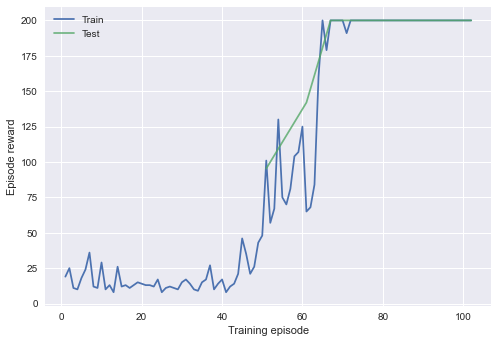

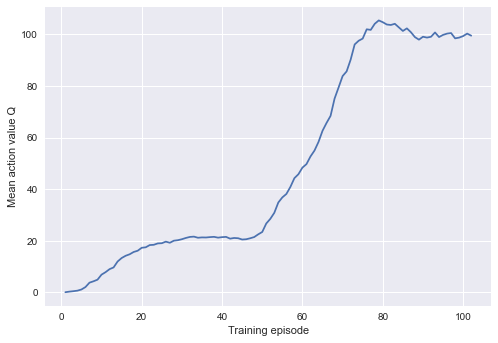

In [4]:
monitor_train = pd.read_csv(path_results_exp / 'monitor_train.csv', index_col=0)

plt.figure()
plt.plot(monitor_train.index, monitor_train['train_reward'], label='Train')
plt.plot(monitor_train.index, monitor_train['test_reward'].interpolate(), label='Test', alpha=0.8)
plt.legend()
plt.xlabel('Training episode')
plt.ylabel('Episode reward')
plt.savefig(path_results_exp / 'training_curve.png', transparent=False)

plt.figure()
plt.plot(monitor_train.index, monitor_train['mean_Q'])
plt.xlabel('Training episode')
plt.ylabel('Mean action value Q')
plt.savefig(path_results_exp / 'mean_Q.png', transparent=False)